### Deadline 2022-07-11 23:59:59

# Домашние задание
1. Добавить Bias и посчитать для них градиенты.
2. Сравнить градинеты с тем, как считает PyTorch AutoGrad.

In [8]:
import numpy as np
import pandas as pd
import torch

In [9]:
# настройки
torch_device = 'cpu'
torch_type = torch.float
batch_size = 64
input_size = 3
hidden_size = 2
output_size = 1

In [10]:
# генерируем исходные данные
x = torch.randn(batch_size, input_size, device=torch_device, dtype=torch_type)
y = torch.randn(batch_size, output_size, device=torch_device, dtype=torch_type)

In [11]:
results = pd.DataFrame(np.zeros((1000, 2)), columns=['Manual', 'AutoGrad'])

### Задание 1

In [12]:
# реализация двухслойной сети "ручками" с добавлением смещения
# дифференцирование со смещением подсмотрено в paper
# Computing Neural Network Gradients автор Kevin Clark:
# https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf
class DoubleLayerNeuroNetWithBias(torch.nn.Module):

    def __init__(self, input_size: int, hidden_size: int, output_size: int, data_type: torch.dtype,
                 learning_rate: float = 1e-6):
        """
        :param input_size: размер входного слоя;
        :param hidden_size: размер скрытых слоев;
        :param output_size:  размер выходного слоя
        """
        # инициализация весов: b1, b2 - смещения, w1,w2 -коэффициенты
        super(DoubleLayerNeuroNetWithBias, self).__init__()
        self.w1 = torch.randn(input_size, hidden_size, device=torch_device, dtype=data_type)
        self.b1 = torch.randn(1, hidden_size, device=torch_device, dtype=data_type)
        self.w2 = torch.randn(hidden_size, output_size, device=torch_device, dtype=data_type)
        self.b2 = torch.randn(1, output_size, device=torch_device, dtype=data_type)
        # инициализируем loss очень большим числом
        self.loss = torch.inf
        # инициализируем learning rate
        self.learning_rate = learning_rate
        pass

    @staticmethod
    def set_relu_activation(layer: torch.Tensor) -> torch.Tensor:
        """
        :param layer: результат работы слоя на который применяем функцию активации;
        :return: "активированные" значения
        """
        return layer.clamp(min=0)

    def get_loss(self) -> float:
        """
        :return: текущее значение loss
        """
        return self.loss

    def set_loss(self, y: torch.Tensor, y_pred: torch.Tensor) -> float:
        """
        :param y: фактические значения целевой переменной;
        :param y_pred: предсказанные значения целевой переменной;
        :return: полученное значение loss
        """
        delta = torch.add(y, y_pred.mul(-1))
        self.loss = torch.pow(delta, 2).sum().item()
        return self.get_loss()

    def set_gradients(self, x: torch.Tensor, y: torch.Tensor):
        dLoss_dypred = 2 * (self.predicted - y)
        dypred_dw2 = self.hidden_layer_1_out.t()ß
        dypred_dh_relu = self.w2.t()ß

        self.grad_w2 = dypred_dw2.mm(dLoss_dypred)
        self.grad_b2 = dLoss_dypred.t().mean()
        self.grad_relu = dLoss_dypred.mm(dypred_dh_relu)
        self.grad_relu[self.hidden_layer_1 < 0] = 0
        self.grad_w1 = x.t().mm(self.grad_relu)
        self.grad_b1 = self.grad_relu.mean()
        pass

    def forward(self, x: torch.Tensor):
        # первый коэффициент
        self.hidden_layer_1 = (x.mm(self.w1)).add(self.b1)
        # активатор
        self.hidden_layer_1_out = self.set_relu_activation(self.hidden_layer_1)
        # результат
        self.hidden_layer_2 = self.hidden_layer_1_out.mm(self.w2)
        self.predicted = self.hidden_layer_2.add(self.b2)
        return self.predicted

    def backward(self, x: torch.Tensor, y: torch.Tensor):
        self.set_gradients(x, y)
        self.w1 -= self.learning_rate * self.grad_w1
        self.b1 -= self.learning_rate * self.grad_b1
        self.w2 -= self.learning_rate * self.grad_w2
        self.b2 -= self.learning_rate * self.grad_b2
        pass


neuro_net = DoubleLayerNeuroNetWithBias(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                                        data_type=torch_type)
for _ in range(1000):
    pred = neuro_net.forward(x)
    results['Manual'][_] = neuro_net.set_loss(y=y, y_pred=pred)
    neuro_net.backward(x, y)

### Задание 2

In [13]:
# Код скопирован из семинарской тетрадки и в него добавлены смещения для первого и второго слоев b1 и b2 соответственно

w1 = torch.randn(input_size, hidden_size, device=torch_device, dtype=torch_type, requires_grad=True)
b1 = torch.randn(1, hidden_size, device=torch_device, dtype=torch_type, requires_grad=True)
w2 = torch.randn(hidden_size, output_size, device=torch_device, dtype=torch_type, requires_grad=True)
b2 = torch.randn(1, output_size, device=torch_device, dtype=torch_type, requires_grad=True)

learning_rate = 1e-6
for t in range(1000):
    y_pred = (x.mm(w1).add(b1)).clamp(min=0).mm(w2).add(b2)

    loss = (y_pred - y).pow(2).sum()

    results['AutoGrad'][t] = loss.item()

    # Теперь подсчет градиентов для весов происходит при вызове backward
    loss.backward()

    # Обновляем значение весов, но указываем, чтобы PyTorch не считал эту операцию,
    # которая бы участвовала при подсчете градиентов в chain rule
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        b1 -= learning_rate * b1.grad
        w2 -= learning_rate * w2.grad
        b2 -= learning_rate * b2.grad

        # Теперь обнуляем значение градиентов, чтобы на следующем шаге
        # они не учитывались при подсчете новых градиентов,
        # иначе произойдет суммирование старых и новых градиентов
        w1.grad.zero_()
        b1.grad.zero_()
        w2.grad.zero_()
        b2.grad.zero_()

### Сравнение

<AxesSubplot:>

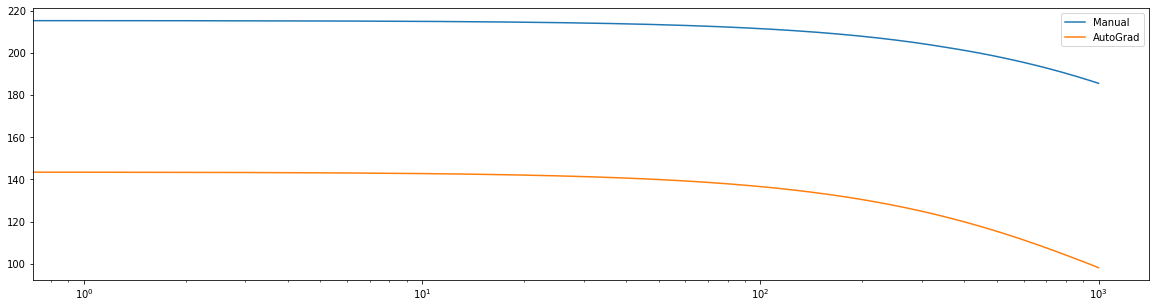

In [14]:
results.plot(figsize=[20, 5], logx=True)

#### Вывод:
Первоначальный вывод был "Ручной способ монотонный и предсказуемый, однако не смотря на "всплеск" AutoGrad достигает оптимального значения раньше.", однако запустив несколько раз тетрадку, было замечено, что AutoGrad может достигать результата как быстрее, так и медленнее, такое поведение обусловлено, на мой взгляд, наличием "случайной" составляющей в алгоритме.